In [36]:
import numpy as np
import pandas as pd
from time import perf_counter
import bisect

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [37]:
def random_search(distance_matrix):
    n = len(distance_matrix)
    solution = list(range(n))
    np.random.shuffle(solution)
    
    return solution[:(n//2)]

In [38]:
def calculate_euclidean_distance(node1, node2):
    return np.round(np.sqrt((node1['x'] - node2['x'])**2 + (node1['y'] - node2['y'])**2))

In [39]:
def get_distance_matrix(df, costs=False):
    num_nodes = df.shape[0]
    distance_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        node1 = df.iloc[i]
        for j in range(i, num_nodes):
            node2 = df.iloc[j]
            distance = calculate_euclidean_distance(node1, node2)
            if costs:
                distance_matrix[i,j] = distance + node2['cost']
                distance_matrix[j,i] = distance + node1['cost']
            else:
                distance_matrix[i,j] = distance
                distance_matrix[j,i] = distance
    return distance_matrix

In [40]:
def compute_node_swap_delta(solution, swap, distance_matrix, costs):
    new_solution = solution[:]
    n = len(new_solution)

    solution_node, outer_node = swap
    solution_node_idx = new_solution.index(solution_node)
    prev_solution_node, next_solution_node = new_solution[solution_node_idx-1], new_solution[(solution_node_idx+1)%n]

    old_cost = distance_matrix[prev_solution_node][solution_node] + distance_matrix[solution_node][next_solution_node] + \
                costs[solution_node]
    new_cost = distance_matrix[prev_solution_node][outer_node] + distance_matrix[outer_node][next_solution_node] + \
                costs[outer_node]
    
    delta = old_cost - new_cost

    return delta



def compute_new_solution_node_swap(solution, swap):
    new_solution = solution[:]

    solution_node, outer_node = swap
    solution_node_idx = new_solution.index(solution_node)
    
    new_solution[solution_node_idx] = outer_node

    return new_solution

In [41]:
def compute_edge_swap_delta(solution, swap, distance_matrix):
    (edge1_start, edge1_end), (edge2_start, edge2_end) = swap
    idx_edge1_start = solution.index(edge1_start)
    idx_edge2_start = solution.index(edge2_start)
    
    old_distance = distance_matrix[edge1_start][edge1_end] + distance_matrix[edge2_start][edge2_end]
    new_distance = distance_matrix[edge1_start][edge2_start] + distance_matrix[edge1_end][edge2_end]
    
    delta = old_distance - new_distance

    return delta



def compute_new_solution_edge_swap(solution, swap):
    (edge1_start, edge1_end), (edge2_start, edge2_end) = swap
    idx_edge1_start = solution.index(edge1_start)
    idx_edge2_start = solution.index(edge2_start)
    
    if idx_edge1_start < idx_edge2_start:
        new_solution = solution[:idx_edge1_start+1] + solution[idx_edge1_start+1:idx_edge2_start+1][::-1] + \
                       solution[idx_edge2_start+1:] 
    else:
        new_solution = solution[:idx_edge2_start+1] + solution[idx_edge2_start+1:idx_edge1_start+1][::-1] + \
                       solution[idx_edge1_start+1:]
    return new_solution

In [42]:
def get_all_node_moves(solution):
    n = len(solution)
    moves = list()
    outer_nodes = list(set(range(int(n*2))) - set(solution))
    for i in range(len(solution)):
        for j in range(len(outer_nodes)):
            moves.append((solution[i], outer_nodes[j]))   
    return moves


def get_all_edge_moves(solution):
    moves = list()
    for i in range(len(solution) - 1):
        for j in range(i + 2, len(solution) - 1):
            edge1 = (solution[i], solution[i + 1])
            edge2 = (solution[j], solution[j + 1])
            moves.append((edge1, edge2))
    return moves

In [43]:
def add_move_to_LM(LM, move_type, move, delta):
    index = bisect.bisect([x[2] for x in LM], delta, key=lambda x: -x)
    LM.insert(index, (move_type, move, delta))


def generate_related_node_moves(solution, affected_node, outer_nodes):
    moves = []
    for outer_node in outer_nodes:
        if outer_node != affected_node:
            moves.append((affected_node, outer_node))
    return moves


def generate_related_edge_moves(solution, affected_edges):
    moves = []
    for i in range(len(solution) - 1):
        for edge in affected_edges:
            if solution[i] not in edge and solution[i + 1] not in edge:
                moves.append((edge, (solution[i], solution[i + 1])))
    return moves


def generate_edge_swaps_for_node_swap(solution, swapped_node):
    moves = []
    swapped_node_index = solution.index(swapped_node)
    n = len(solution)

    adjacent_edges = [
        (solution[swapped_node_index], solution[(swapped_node_index + 1) % n]),
        (solution[swapped_node_index - 1], solution[swapped_node_index])
    ]

    for i in range(n - 1):
        for edge in adjacent_edges:
            other_edge = (solution[i], solution[i + 1])
            if set(edge).isdisjoint(set(other_edge)):
                moves.append((edge, other_edge))
    
    return moves



def add_new_moves_to_LM(solution, previous_move, LM, distance_matrix, costs):
    move_type, last_move, _ = previous_move

    if move_type == 'node_swap':
        affected_node = last_move[1]
        # print(affected_node in solution)
        outer_nodes = list(set(range(len(solution)*2)) - set(solution))

        related_node_moves = generate_related_node_moves(solution, affected_node, outer_nodes)
        for move in related_node_moves:
            delta = compute_node_swap_delta(solution, move, distance_matrix, costs)
            if delta > 0:
                add_move_to_LM(LM, 'node_swap', move, delta)

        related_edge_moves = generate_edge_swaps_for_node_swap(solution, affected_node)
        for move in related_edge_moves:
            delta = compute_edge_swap_delta(solution, move, distance_matrix)
            if delta > 0:
                add_move_to_LM(LM, 'edge_swap', move, delta)

    elif move_type == 'edge_swap':
        affected_edges = [last_move[0], last_move[1]]
        related_moves = generate_related_edge_moves(solution, affected_edges)
        for move in related_moves:
            delta = compute_edge_swap_delta(solution, move, distance_matrix)
            if delta > 0:
                add_move_to_LM(LM, 'edge_swap', move, delta)
    
    return LM


In [44]:
def edge_exists(solution, edge):
    try:
        idx = solution.index(edge[0])
        return solution[(idx + 1) % len(solution)] == edge[1] or solution[idx - 1] == edge[1]
    except ValueError:
        return False



def move_is_applicable(solution, move):
    move_type, move_data, _ = move

    if move_type == 'node_swap':
        solution_node, outer_node = move_data
        return solution_node in solution and outer_node not in solution

    elif move_type == 'edge_swap':
        (edge1_start, edge1_end), (edge2_start, edge2_end) = move_data
        return edge_exists(solution, (edge1_start, edge1_end)) and edge_exists(solution, (edge2_start, edge2_end))

    return False


In [45]:
def steepest_local_search_deltas(solution, distance_matrix, costs):
    LM = []
    first_iteration_flag = True
    
    while True:

        if first_iteration_flag:
            
            all_node_moves = get_all_node_moves(solution)
            for node_move in all_node_moves:
                delta = compute_node_swap_delta(solution, node_move, distance_matrix, costs)
                if delta > 0:
                    LM.append( ('node_swap', node_move, delta) )
                    
            all_edge_moves = get_all_edge_moves(solution)
            for edge_move in all_edge_moves:
                delta = compute_edge_swap_delta(solution, edge_move, distance_matrix)
                if delta > 0:
                    LM.append( ('edge_swap', edge_move, delta) )
                    
            LM.sort(key=lambda x: x[2], reverse=True)
            move = LM.pop(0)
            previous_move = move
            if move[0] == 'node_swap':
                solution = compute_new_solution_node_swap(solution, move[1])
            elif move[0] == 'edge_swap':
                solution = compute_new_solution_edge_swap(solution, move[1])
            first_iteration_flag = False
        
        else:
            # if previous_move[0] =='node_swap':
            #     print(previous_move[1][1] in solution, previous_move[1][0] in solution)
            LM = add_new_moves_to_LM(solution, previous_move, LM, distance_matrix, costs)
            # print(1)
            total_cost = sum(distance_matrix_with_costs[solution[i]][solution[i+1]] for i in range(len(solution) - 1))
            total_cost += distance_matrix_with_costs[solution[-1]][solution[0]]
            print(total_cost)
            print(len(LM))
            print(LM[:5])
            while True:
                # print(0)
                if len(LM) == 0:
                    return solution
                move = LM.pop(0)
                if move_is_applicable(solution, move):
                    # previous_move = move
                    if move[0] == 'node_swap':
                        if compute_node_swap_delta(solution, move[1], distance_matrix, costs) > 0:
                            solution = compute_new_solution_node_swap(solution, move[1])
                            previous_move = move
                            print(move)
                        else:
                            print('here', move)
                    elif move[0] == 'edge_swap':
                        if compute_edge_swap_delta(solution, move[1], distance_matrix) > 0:
                            solution = compute_new_solution_edge_swap(solution, move[1])
                            previous_move = move
                            print(move)
                    break
            print(len(LM))
            print(LM[:5])
            print()

In [46]:
df = pd.read_csv('../data/TSPA.csv', names=['x', 'y', 'cost'], sep=';')
costs = df.cost
distance_matrix = get_distance_matrix(df)
distance_matrix_with_costs = get_distance_matrix(df, True)
solutionn = random_search(distance_matrix)

In [47]:
total_cost = sum(distance_matrix_with_costs[solutionn[i]][solutionn[i+1]] for i in range(len(solutionn) - 1))
total_cost += distance_matrix_with_costs[solutionn[-1]][solutionn[0]]
total_cost

261704.0

In [48]:
solutionnn = steepest_local_search_deltas(solutionn, distance_matrix, costs)

254767.0
6909
[('node_swap', (183, 95), 6531.0), ('node_swap', (56, 109), 6340.0), ('node_swap', (183, 169), 6305.0), ('node_swap', (56, 130), 6172.0), ('node_swap', (183, 26), 6128.0)]
('node_swap', (183, 95), 6531.0)
6908
[('node_swap', (56, 109), 6340.0), ('node_swap', (183, 169), 6305.0), ('node_swap', (56, 130), 6172.0), ('node_swap', (183, 26), 6128.0), ('node_swap', (56, 199), 6083.0)]

248236.0
6944
[('node_swap', (56, 109), 6340.0), ('node_swap', (183, 169), 6305.0), ('node_swap', (56, 130), 6172.0), ('node_swap', (183, 26), 6128.0), ('node_swap', (56, 199), 6083.0)]
('edge_swap', ((147, 11), (64, 16)), 5819.0)
6931
[('edge_swap', ((92, 181), (13, 183)), 5813.0), ('node_swap', (56, 137), 5784.0), ('node_swap', (183, 112), 5769.0), ('edge_swap', ((64, 16), (74, 152)), 5660.0), ('node_swap', (56, 101), 5638.0)]

242417.0
7046
[('edge_swap', ((92, 181), (13, 183)), 5813.0), ('node_swap', (56, 137), 5784.0), ('node_swap', (183, 112), 5769.0), ('edge_swap', ((64, 16), (74, 152)), 5

KeyboardInterrupt: 

In [ ]:
total_cost = sum(distance_matrix_with_costs[solution[i]][solution[i+1]] for i in range(len(solution) - 1))
total_cost += distance_matrix_with_costs[solution[-1]][solution[0]]
total_cost

NameError: name 'solution' is not defined

In [ ]:
# columns = ["Algorithm", "TSPA", "TSPB", "TSPC", "TSPD"]
# cost_df = pd.DataFrame(columns=columns)
# time_df = pd.DataFrame(columns=columns)
# best_solutions = {}

# instances = ['TSPA', 'TSPB', 'TSPC', 'TSPD']
# path = "../data/"

# algo_name = 'Steepest-CandidateMovesEdges-Random'
# new_row = pd.DataFrame({columns[0]: algo_name}, index=[0])
# cost_df = pd.concat([cost_df, new_row], ignore_index=True)
# time_df = pd.concat([time_df, new_row], ignore_index=True)
# best_solutions_tmp = {}

# for instance in instances:
#     file_name = f'{path}{instance}.csv'
#     df = pd.read_csv(file_name, names=['x', 'y', 'cost'], sep=';')
#     distance_matrix = get_distance_matrix(df)
#     distance_matrix_with_costs = get_distance_matrix(df, True)
#     costs = df.cost.values
#     total_costs, solutions, times = list(), list(), list()
#     candidate_moves = get_candidate_moves(distance_matrix, costs)
#     print(algo_name, instance)
#     for i in range(200):
#         print(i)
#         solution = random_search(distance_matrix_with_costs)
#         start_time = perf_counter()
#         solution = steepest_local_search(solution, distance_matrix, costs, candidate_moves)
#         total_cost = sum(distance_matrix_with_costs[solution[i]][solution[i+1]] for i in range(len(solution) - 1))
#         total_cost += distance_matrix_with_costs[solution[-1]][solution[0]]
#         end_time = perf_counter()
#         total_costs.append(total_cost)
#         solutions.append(solution)
#         times.append(round(end_time - start_time, 3))
#     best_solution_idx = np.argmin(total_costs)
#     best_solutions_tmp[file_name] = solutions[best_solution_idx]
#     cost_df.at[cost_df.index[-1], instance] = f'{np.mean(total_costs)} ({np.min(total_costs)} - {np.max(total_costs)})'
#     time_df.at[time_df.index[-1], instance] = f'{round(np.mean(times), 3)} ({np.min(times)} - {np.max(times)})'
#     print(f'{np.mean(total_costs)} ({np.min(total_costs)} - {np.max(total_costs)})')
#     print(f'{np.mean(times)} ({np.min(times)} - {np.max(times)})')
#     print(solutions[best_solution_idx])
#     display(cost_df)
#     display(time_df)
# best_solutions[algo_name] = best_solutions_tmp

In [ ]:
# cost_df.to_csv('costs.csv')

In [ ]:
# time_df.to_csv('times.csv')

In [ ]:
# display(cost_df)

In [ ]:
# display(time_df)

In [ ]:
best_solutions = {}
best_solutions['algo'] = {}
best_solutions['algo']['../data/TSPA.csv'] = solution

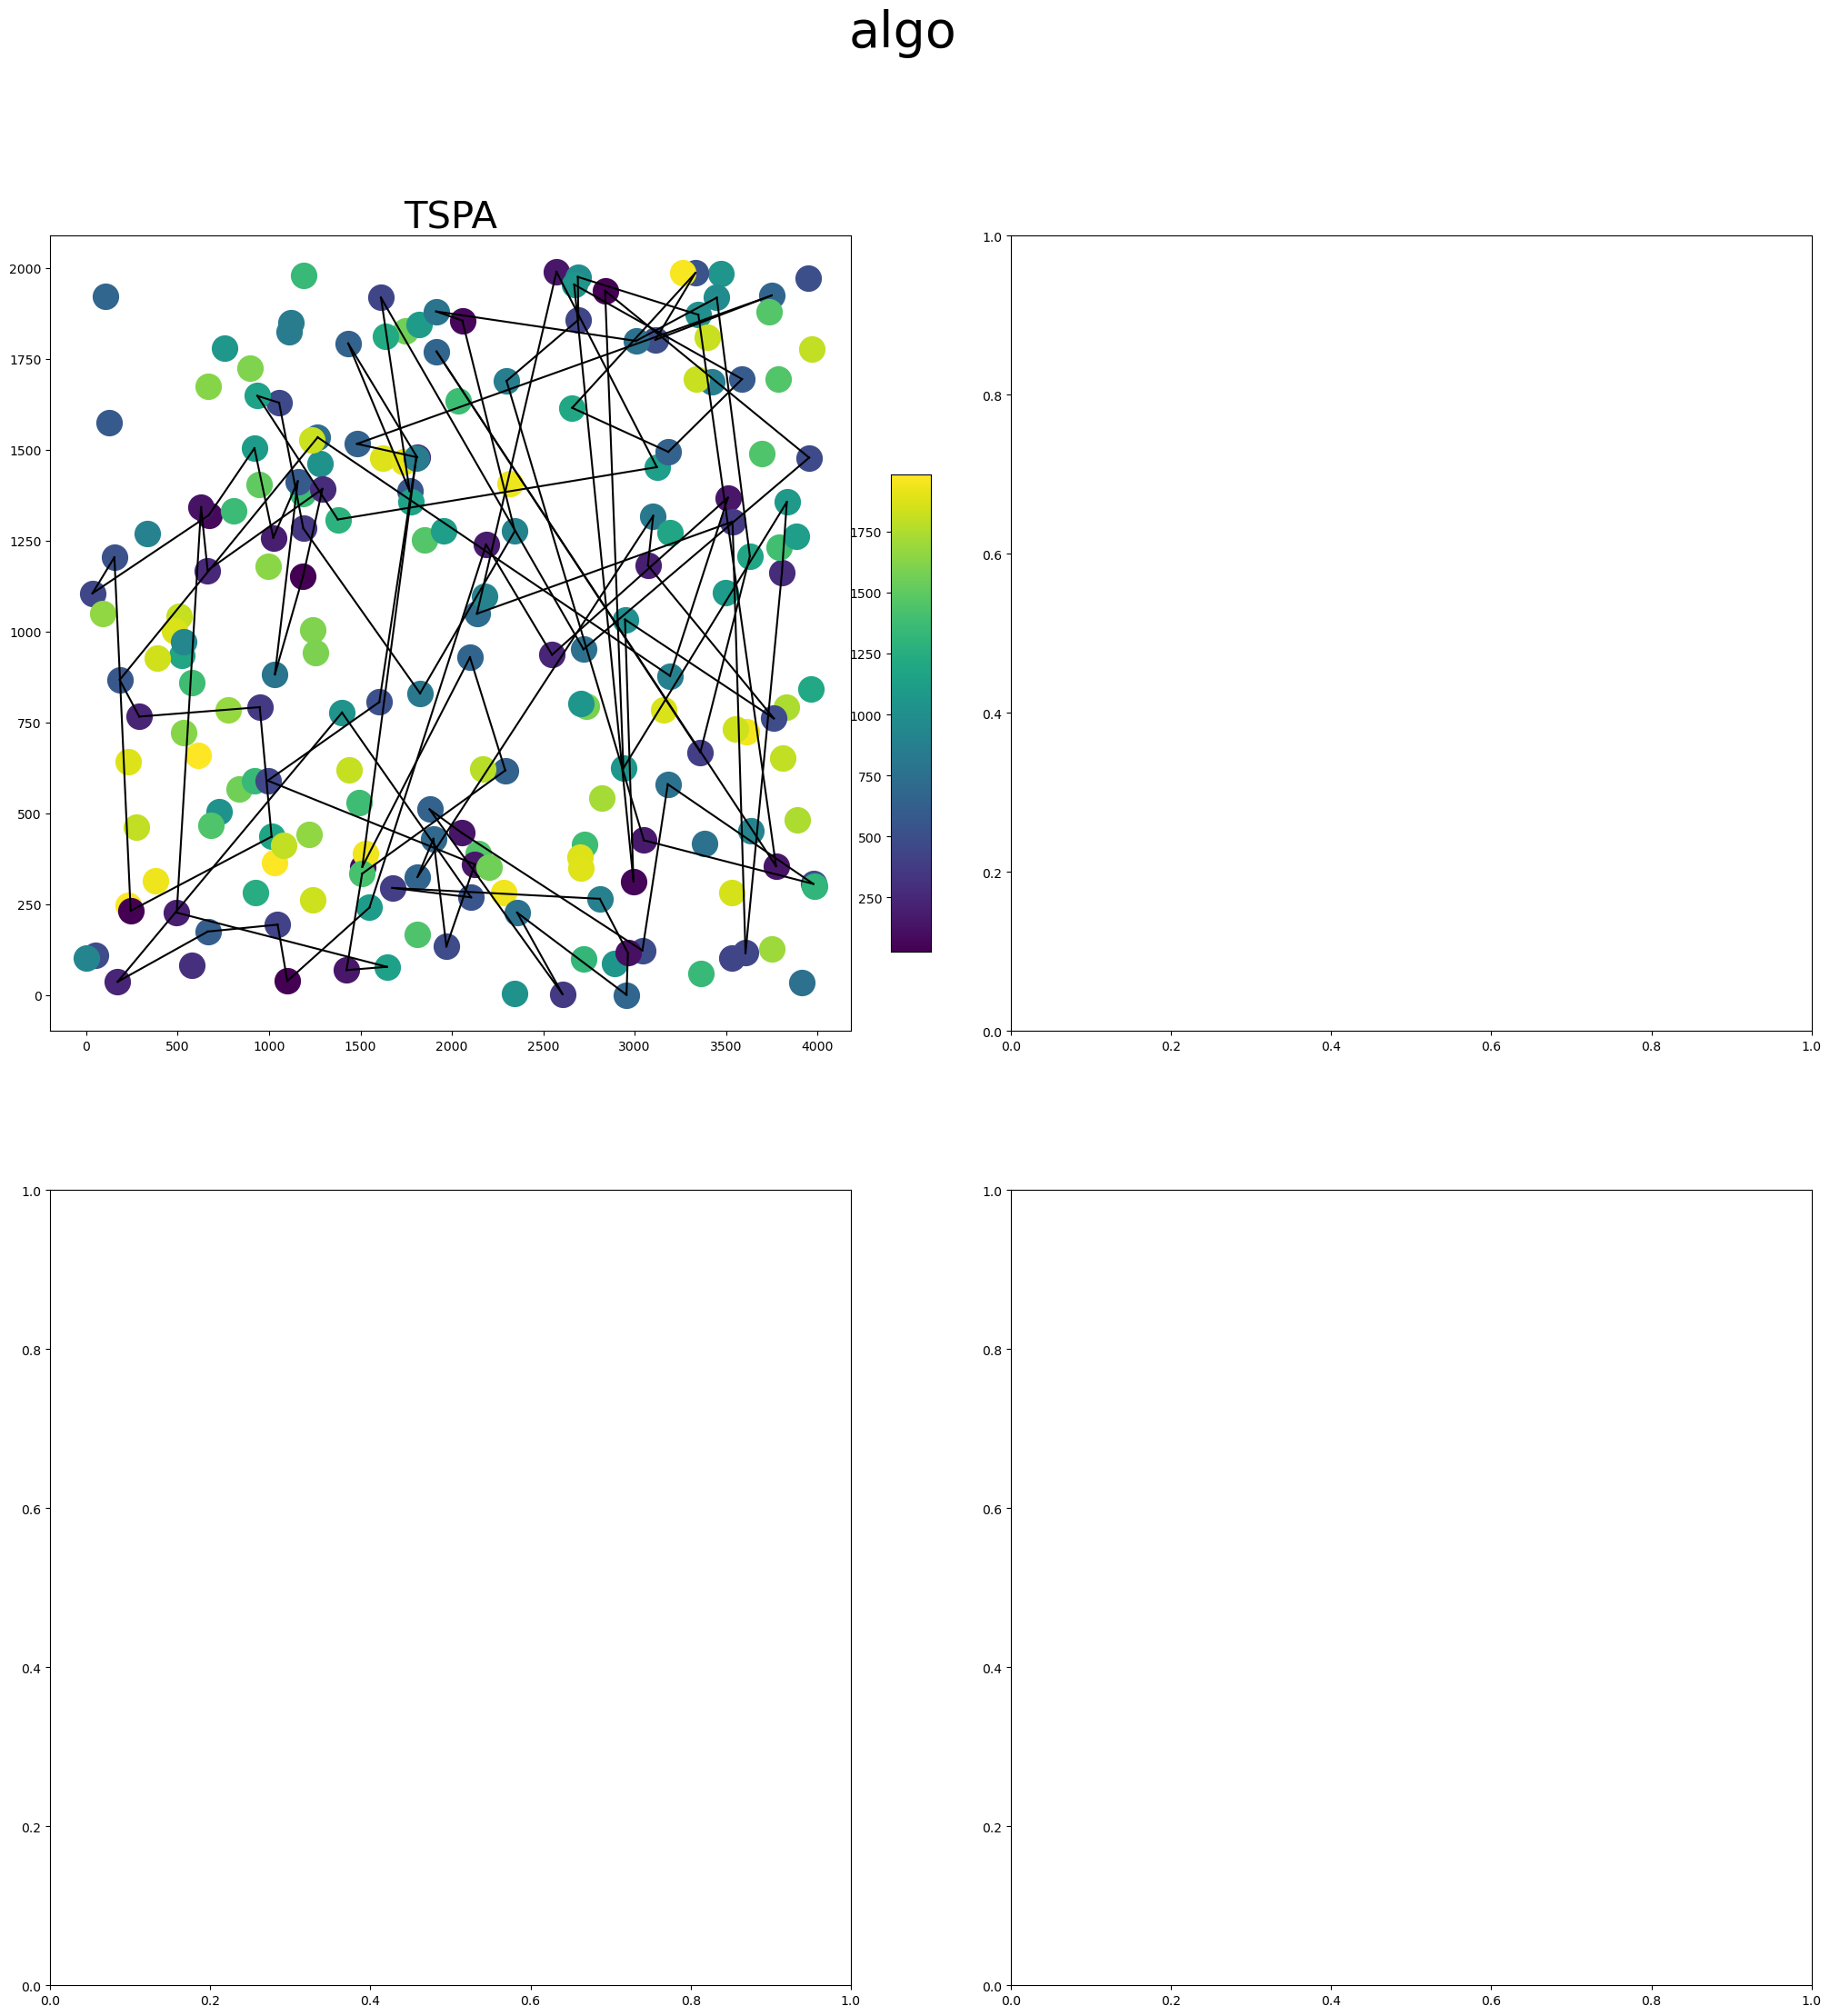

In [ ]:
for algo in best_solutions:
    fig, ax = plt.subplots(2, 2, figsize=(25, 25))
    ax = ax.flatten()
    idx = 0
    fig.suptitle(algo, fontsize=40)
    for instance in best_solutions[algo]:
        solution = best_solutions[algo][instance]
        df = pd.read_csv(instance, names=['x', 'y', 'cost'], sep=';')
        weights = df['cost']
        cmap = plt.cm.viridis
        norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
        ax[idx].set_title(instance.replace('../data/', '').replace('.csv', ''), fontsize=30)
        for i in range(len(df)):
            x, y, cost = df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['cost']
            ax[idx].plot(x, y, "o", markersize=20, color=cmap(norm(cost)))
        for i in range(len(solution)-1):
            x, y, cost = df.iloc[solution[i]]['x'], df.iloc[solution[i]]['y'], df.iloc[solution[i]]['cost']
            x_next, y_next = df.iloc[solution[i+1]]['x'], df.iloc[solution[i+1]]['y']
            ax[idx].plot((x, x_next), (y, y_next), "-", color='black')
        x, y = df.iloc[solution[0]]['x'], df.iloc[solution[0]]['y']
        ax[idx].plot((x, x_next), (y, y_next), "-", color='black')
        
        axins = ax[idx].inset_axes([1.05, 0.1, 0.05, 0.6], transform=ax[idx].transAxes)
        gradient = np.linspace(0, 1, 256).reshape(-1, 1)

        axins.imshow(gradient, aspect='auto', cmap=cmap, origin='lower', extent=[0, 1, min(weights), max(weights)])
        axins.xaxis.set_visible(False)
        
        idx += 1
        
    # plt.savefig(f'./plots/{algo}.png', dpi=300)
    plt.show()